Q1: Why is the KL Divergence term important in the VAE loss function?
The KL Divergence term in the VAE loss function regularizes the latent space by minimizing the difference between the learned distribution and a standard Gaussian distribution. This helps ensure that the latent space is smooth and continuous, which is critical for meaningful data generation from any point within the latent space​.

Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?
A critical challenge in training VAEs is that sampling directly from the latent distribution disrupts the ackpropagation process, making it non-differentiable. The reparameterization trick solves this by transforming the random sampling into a differentiable function.

Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?
A VAE uses a probabilistic latent space to enable the generation of diverse outputs. By mapping data into distributions defined by a mean and variance, the model can sample different points to produce varied outputs. This probabilistic approach contrasts with traditional autoencoders, which map data to fixed points, limiting output diversity​.

Q4: What role does KL Divergence play in ensuring a smooth latent space?
KL Divergence ensures a smooth latent space by encouraging the learned latent distributions to closely resemble a standard Gaussian distribution. This regularization promotes continuity and coherence in the latent space, allowing the model to generate realistic data even from points that were not explicitly part of the training dat

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 128x4x4
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space
        self.fc_mu = nn.Linear(256*2*2, latent_dim)
        self.fc_logvar = nn.Linear(256*2*2, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256*2*2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 256, 2, 2)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Batch [{batch_idx}] Loss: {loss.item():.4f}')

def generate_images(model, num_images=10, latent_dim=128):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        sample = model.decode(z)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images*1.5, 1.5))
    for i, ax in enumerate(axes):
        img = sample[i].cpu().numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
model = ConvVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 20
print(f"Training on device: {device}")

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, epoch)


print("Training completed!")

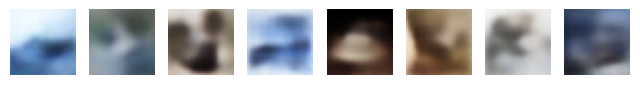

In [61]:
# Generate final sample of images
generate_images(model, num_images=8)

In [5]:
# Define VAE for CIFAR-10
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 32x32x3 = 3072 for CIFAR-10

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))  # Output shape: (batch_size, 3072)

    def forward(self, x):
        x = x.view(-1, self.input_dim)  # Flatten CIFAR-10 images
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [71]:

# Loss function for CIFAR-10 VAE
def loss_function(recon_x, x, mu, logvar):   
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [72]:

# Training function
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [ ]:
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(input_dim=3072, hidden_dim=512, latent_dim=128).to(device)  # Adjusted input and hidden sizes
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Train the VAE
for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)

Epoch 1, Loss: 1978.6205953125
Epoch 2, Loss: 1908.1568640625
Epoch 3, Loss: 1886.9140340625
Epoch 4, Loss: 1876.88790125
Epoch 5, Loss: 1870.4409365625
Epoch 6, Loss: 1863.3167334375
Epoch 7, Loss: 1858.3018465625
Epoch 8, Loss: 1855.3915734375
Epoch 9, Loss: 1853.4708328125
Epoch 10, Loss: 1852.108405625


In [108]:
def generate_images(model, num_images=10, latent_dim=128):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space
        z = torch.randn(num_images, latent_dim).to(device)  # Ensure it's on the right device
        # Decode to generate images
        generated_images = model.decode(z).cpu().numpy()  # Convert to NumPy array

    # Reshape the images (batch_size, 3, 32, 32)
    generated_images = generated_images.reshape(num_images, 3, 32, 32)
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        axs[i].axis('off')
    plt.show()

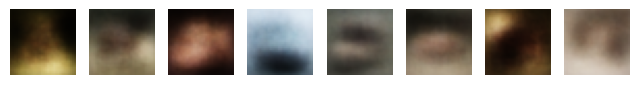

In [109]:
generate_images(vae, num_images=8, latent_dim=128)

Question 2

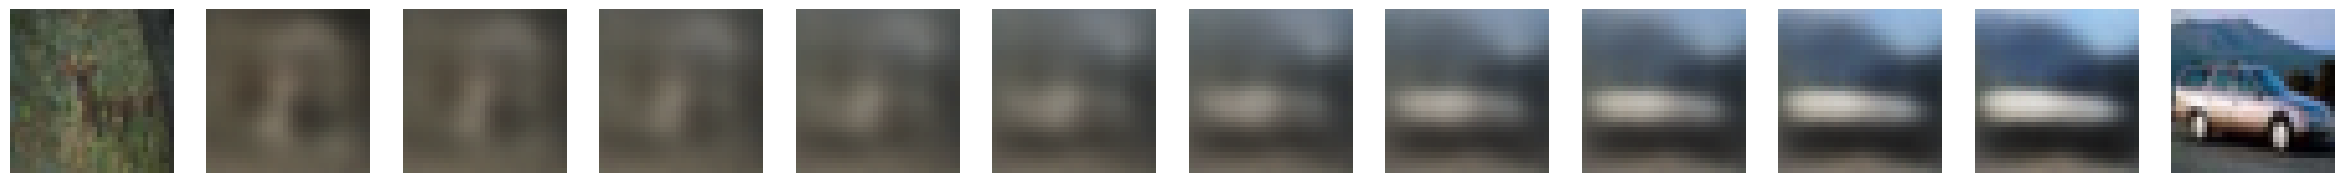

In [89]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Function to interpolate between two latent vectors
def interpolate_latent_space(model, img1, img2, num_steps=20):
    model.eval()
    with torch.no_grad():
        # Encode the images to get their latent representations
        mu1, logvar1 = model.encode(img1.unsqueeze(0).to(device))
        z1 = model.reparameterize(mu1, logvar1)
        mu2, logvar2 = model.encode(img2.unsqueeze(0).to(device))
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_z = [z1 * (1 - x) + z2 * x for x in np.linspace(0, 1, num_steps)]
        interpolated_imgs = [model.decode(z).cpu().squeeze(0) for z in interpolated_z]
        
    return interpolated_imgs
img1, _ = train_dataset[np.random.randint(1,11)]
img2, _ = train_dataset[np.random.randint(1,11)]
interpolated_images = interpolate_latent_space(model, img1, img2, num_steps=10)
interpolated_images = [img1] + interpolated_images + [img2]

fig, axes = plt.subplots(1, len(interpolated_images), figsize=(30, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(interpolated_images[i].permute(1, 2, 0))
    ax.axis('off')
plt.show()

Question 3 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Resize, ToTensor

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = Compose([
    Resize((64, 64)),
    ToTensor(),
])
dataset = datasets.MNIST(root='./data', download=True, transform=transform)

# Limit the dataset to the first 51183 images
max_index = 51183
subset = Subset(dataset, range(max_index))
loader = DataLoader(subset, batch_size=128, shuffle=True)

class MNISTVAE(nn.Module):
    def __init__(self, latent_dim):
        super(MNISTVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 256, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
import torch.nn.functional as F

# Define the loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training the VAE
def train_vae(model, dataloader, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}')

def show_images(images, title):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.axis('off')
    plt.show()

# Initialize the model
latent_dim = 20
mnist_vae = MNISTVAE(latent_dim).to(device)

# Train the VAE on CelebA dataset
train_vae(mnist_vae, loader, epochs=10, lr=1e-3)

# Sample from different regions of the latent space
mnist_vae.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample_celeba = mnist_vae.decode(z).cpu()

# Visualize the generated samples
show_images(sample_celeba, "Generated Images from MNISTVAE")

# Experiment with sampling from different regions of the latent space
def sample_and_show(latent_vectors, title):
    mnist_vae.eval()
    with torch.no_grad():
        samples = mnist_vae.decode(latent_vectors).cpu()
    show_images(samples, title)

# Generate latent vectors from different regions
z1 = torch.randn(64, latent_dim).to(device)  # Standard normal distribution
z2 = torch.ones(64, latent_dim).to(device)   # All ones
z3 = torch.zeros(64, latent_dim).to(device)  # All zeros
z4 = torch.linspace(-2, 2, steps=64).unsqueeze(1).repeat(1, latent_dim).to(device)  # Linearly spaced values

# Show generated images for each set of latent vectors
sample_and_show(z1, "Samples from Standard Normal Distribution")
sample_and_show(z2, "Samples from All Ones")
sample_and_show(z3, "Samples from All Zeros")
sample_and_show(z4, "Samples from Linearly Spaced Values")

Epoch 1, Loss: 808.0932082857101
Epoch 2, Loss: 518.7130929092667
Epoch 3, Loss: 503.3356000924379
Epoch 4, Loss: 496.1971037136354
Epoch 5, Loss: 492.1153626295596
Epoch 6, Loss: 489.1851214331419
Epoch 7, Loss: 486.86232939586876
